# Data Literacy
#### University of Tübingen, Winter Term 2021/22
## Exercise Sheet 5 (Solution)
&copy; 2021 Prof. Dr. Philipp Hennig & Lukas Tatzel

This sheet is **due on Monday 29 November 2021 at 10 am sharp (i.e. before the start of the lecture).**

---

## Hypothesis Testing & *Hunting* for Significance 

**What is this week's tutorial about?** In this week's tutorial, we will analyze data from the 1. Fußball-Bundesliga (the German premier soccer league). The goal is to investigate the effect of the Corona pandemic on the teams' performances. More precisely, we will try to find teams that achieved significantly worse results in the first "Corona-year" 2020 than in previous years (possibly caused by empty stadiums, etc.). For that purpose, we will conduct multiple hypotheses tests and discuss whether and how we should therefore adapt our strategy. 

In [1]:
# Make inline plots vector graphics
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

### 1. Load and prepare the Data

In this tutorial, we will use data provided by [OpenLigaDB](https://www.openligadb.de/). The function `get_league_table` allows you to retrieve the data via the API interface and convert it into a Pandas data frame.

In [2]:
import requests

API_ENDPOINT = "https://www.openligadb.de/api"

def get_league_table(league, year):
    """
    Get team rankings as Pandas data frame.
    
    Parameters
    ----------
    league : str
        'bl1' for 1. Bundesliga, see https://github.com/OpenLigaDB/OpenLigaDB-Samples
    year : int
        Get data for this year
    """
    response = requests.get(f"{API_ENDPOINT}/getbltable/{league}/{year}")
    data = response.json()
    return pd.DataFrame(data)

# Get and display data for the 1. Bundesliga ('bl1') for 2020
data = get_league_table(league="bl1", year=2020)
display(data.head())

TeamInfoId             TeamName  ShortName  \
0          40    FC Bayern München     Bayern   
1        1635           RB Leipzig    Leipzig   
2           7    Borussia Dortmund        BVB   
3         131        VfL Wolfsburg  Wolfsburg   
4          91  Eintracht Frankfurt  Frankfurt   

                                         TeamIconUrl  Points  OpponentGoals  \
0                    https://i.imgur.com/jJEsJrj.png      78             44   
1                    https://i.imgur.com/Rpwsjz1.png      65             32   
2  https://upload.wikimedia.org/wikipedia/commons...      64             46   
3                    https://i.imgur.com/ucqKV4B.png      61             37   
4                    https://i.imgur.com/X8NFkOb.png      60             53   

   Goals  Matches  Won  Lost  Draw  GoalDiff  
0     99       34   24     4     6        55  
1     60       34   19     7     8        28  
2     75       34   20    10     4        29  
3     61       34   17     7    10        24  
4     69       34   16     6    12        16

**Task:** Your first task is to essentially recreate the following table:

<br />

<div>
<img src="Table.PNG" width="750"/>
</div>

**Recommended Steps:**
1. First, gather data for all years from 2010 to 2020 and store this data into a single Pandas data frame. Each time you receive a data frame from `get_league_table`, extract the relevant columns and add the corresponding year as a new column `"year"`.
2. Split this data frame into two separate data frames: One for the year 2020, the other one for the accumulated results from 2010 to 2019. 
3. Merge the two data frames on the `"TeamName"`-column. Make sure that you only include teams that played in 2020 and also in at least one other season in the past. 

In [3]:
start_year = 2010
end_year   = 2020

# Gather data for all years
data_all_years = []
for year in range(start_year, end_year + 1):

    # Get data, extract relevant columns and append to data_all_years
    data = get_league_table("bl1", year)
    data = data[["TeamName", "Matches", "Won", "Draw", "Lost"]]
    data["Year"] = year
    data_all_years.append(data)

# Transform list into one single data frame
data_all_years = pd.concat(data_all_years)
# with pd.option_context("display.max_rows", None):
#     display(data_all_years)

In [4]:
# Data 2020
data_2020 = (
    data_all_years[data_all_years["Year"] == 2020]
    .drop("Year", axis=1)
    .rename(
        columns={
            "Matches": "Matches2020",
            "Won":     "Won2020",
            "Draw":    "Draw2020",
            "Lost":    "Lost2020",
        }
    )
)
# display(data_2020)

# Data before 2020
data_pre2020 = (
    data_all_years[data_all_years["Year"] < 2020]
    .groupby("TeamName")
    .sum()
    .drop("Year", axis=1)
    .reset_index()
    .rename(
        columns={
            "Matches": "MatchesPre2020",
            "Won":     "WonPre2020",
            "Draw":    "DrawPre2020",
            "Lost":    "LostPre2020",
        }
    )
)
# display(data_pre2020)

In [5]:
# Merge data frames ("inner" makes shure we have current AND historical data)
data = data_2020.merge(data_pre2020, how="inner", on="TeamName")
display(data)

TeamName  Matches2020  Won2020  Draw2020  Lost2020  \
0          FC Bayern München           34       24         6         4   
1                 RB Leipzig           34       19         8         7   
2          Borussia Dortmund           34       20         4        10   
3              VfL Wolfsburg           34       17        10         7   
4        Eintracht Frankfurt           34       16        12         6   
5           Bayer Leverkusen           34       14        10        10   
6         1. FC Union Berlin           34       12        14         8   
7   Borussia Mönchengladbach           34       13        10        11   
8              VfB Stuttgart           34       12         9        13   
9                SC Freiburg           34       12         9        13   
10       TSG 1899 Hoffenheim           34       11        10        13   
11           1. FSV Mainz 05           34       10         9        15   
12               FC Augsburg           34       10         6        18   
13                Hertha BSC           34        8        11        15   
14                1. FC Köln           34        8         9        17   
15             Werder Bremen           34        7        10        17   
16             FC Schalke 04           34        3         7        24   

    MatchesPre2020  WonPre2020  DrawPre2020  LostPre2020  
0              340         255           47           38  
1              136          72           36           28  
2              340         203           72           65  
3              340         127           92          121  
4              306         105           75          126  
5              340         171           73           96  
6               34          12            5           17  
7              340         152           75          113  
8              272          87           57          128  
9              306          96           85          125  
10             340         120          100          120  
11             340         118           81          141  
12             306          91           84          131  
13             272          88           69          115  
14             238          67           63          108  
15             340         105           93          142  
16             340         140           81          119

### 2. Compute p-Values

Our goal is to find out if there are teams that achieved significantly worse results in 2020 than in previous years. In the lecture, you already learned about a statistical test for this purpose: 

- First, we put a beta-prior on $f_0$ (the winning probability before 2020) which is based on $m_0$ (the number of wins before 2020) in $n_0$ matches (the number of matches before 2020).

- Under the null hypothesis $H_0: f_1 = f_0$, the number of wins in 2020 $m_1$ (given the number of matches in 2020 $n_1$) follows a binomial distribution. 

- Putting these building blocks together, we obtain a [beta-binomial distribution](https://en.wikipedia.org/wiki/Beta-binomial_distribution)

    \begin{equation}
    p(m_1 \vert n_1, m_0, n_0) 
    = {n_1\choose m_1} 
    \frac{\mathcal{B}(m_0 + m_1 + 1, (n_0-m_0) + (n_1-m_1) + 1)}
    {\mathcal{B}(m_0 + 1, n_0 - m_0 + 1)}.
    \end{equation}

    This tells us the probability to observe $m_1$ wins in 2020, given the number of matches in 2020 $n_1$ and the statistics $m_0$, $n_0$ for the years before. 

**Task:** Plot $p(m_1 \vert n_1, m_0, n_0)$ for $m_1 \in \{0, 1, ..., n_1\}$ for some arbitrary numbers $n_1$, $m_0$ and $n_0$. Play around with these parameters to gain some intuition how this distribution behaves. 

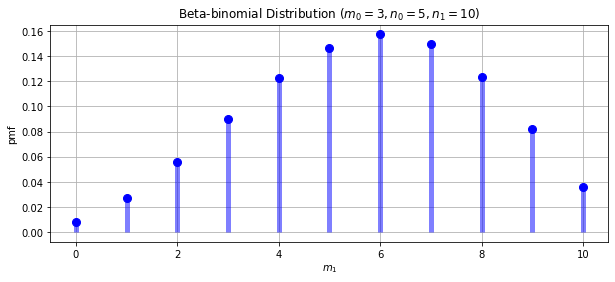

In [6]:
from scipy.stats import betabinom

# Choose parameters
m_0 = 3
n_0 = 5
n_1 = 10
m_1_vec = np.arange(n_1 + 1)

# Determine coefficients by comparison to 
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.betabinom.html
# Evaluate pmf
betabinom_pmf = betabinom.pmf(k=m_1_vec, n=n_1, a=m_0+1, b=n_0-m_0+1)

# Plot distribution
fig, ax = plt.subplots(1, 1, figsize=[10, 4])
ax.plot(m_1_vec, betabinom_pmf, 'bo', ms=8)  # points
ax.vlines(m_1_vec, 0, betabinom_pmf, colors='b', lw=5, alpha=0.5)  # lines

ax.grid()
ax.set_xlabel("$m_1$")
ax.set_ylabel("pmf")
ax.set_title(rf"Beta-binomial Distribution ($m_0 = {m_0}, n_0 = {n_0}, n_1 = {n_1}$)")
plt.show()

- The $p$-value represents the probability to observe a certain number of wins or *more extreme* results. Let's assume, the team we consider has won $3$ times in 2020. Since we are interested in teams that have played particularly badly, we sum $p(m_1 \vert n_1, m_0, n_0)$ over $m_1 = 0, 1, 2, 3$. Evaluating the cumulative distribution function `betabinom.cdf` performs this summation for us. 

- If this probability is small, then it is very unlikely that the observed data has been generated from the winning probability $f_0$. Or, in other words, the team has played particularly badly in 2020. We thus reject $H_0$ if $p \leq \alpha := 5 \%$. 

**Task:** Compute the $p$-values for every team and add the results as a new column `"p-value (won)"`. Check if there are teams whose $p$-value falls below the $5 \%$ threshold. 

In [7]:
def p_val_won(m_1, n_1, m_0, n_0):
    """
    Compute p-value by summing the evidence p(m_1 | n_1, m_0, n_0) over the 
    observed number of wins and 'more extreme' (i.e. smaller) results.
    
    Parameters
    ----------
    m_1 : int
        Number of wins in 2020 (0 <= m_1 <= n_1)
    n_1 : int
        Number of matches in 2020 (n_1 > 0)
    m_0 : int
        Number of wins before 2020 (0 <= m_0 <= n_0)
    n_0 : int
        Number of matches before 2020 (n_0 > 0)
    """
    return betabinom.cdf(m_1, n_1, m_0 + 1, n_0 - m_0 + 1)

In [8]:
# Compute p-value for all teams
p_val_list = []
for index, row in data.iterrows():
    p_val_list.append(
        p_val_won(
            m_1=row["Won2020"],
            n_1=row["Matches2020"],
            m_0=row["WonPre2020"],
            n_0=row["MatchesPre2020"],
        )
    )
data["p-value (won)"] = p_val_list
display(data)

# Significant results?
alpha = 0.05
if data[data["p-value (won)"] <= alpha].empty:
    print("No significant results")
else:
    print("Significant results:")
    display(data[data["p-value (won)"] <= alpha])

TeamName  Matches2020  Won2020  Draw2020  Lost2020  \
0          FC Bayern München           34       24         6         4   
1                 RB Leipzig           34       19         8         7   
2          Borussia Dortmund           34       20         4        10   
3              VfL Wolfsburg           34       17        10         7   
4        Eintracht Frankfurt           34       16        12         6   
5           Bayer Leverkusen           34       14        10        10   
6         1. FC Union Berlin           34       12        14         8   
7   Borussia Mönchengladbach           34       13        10        11   
8              VfB Stuttgart           34       12         9        13   
9                SC Freiburg           34       12         9        13   
10       TSG 1899 Hoffenheim           34       11        10        13   
11           1. FSV Mainz 05           34       10         9        15   
12               FC Augsburg           34       10         6        18   
13                Hertha BSC           34        8        11        15   
14                1. FC Köln           34        8         9        17   
15             Werder Bremen           34        7        10        17   
16             FC Schalke 04           34        3         7        24   

    MatchesPre2020  WonPre2020  DrawPre2020  LostPre2020  p-value (won)  
0              340         255           47           38       0.348167  
1              136          72           36           28       0.677643  
2              340         203           72           65       0.523893  
3              340         127           92          121       0.944680  
4              306         105           75          126       0.947118  
5              340         171           73           96       0.197757  
6               34          12            5           17       0.536227  
7              340         152           75          113       0.288884  
8              272          87           57          128       0.713822  
9              306          96           85          125       0.739930  
10             340         120          100          120       0.436111  
11             340         118           81          141       0.330397  
12             306          91           84          131       0.560026  
13             272          88           69          115       0.191480  
14             238          67           63          108       0.354132  
15             340         105           93          142       0.139969  
16             340         140           81          119       0.000065

Significant results:


TeamName  Matches2020  Won2020  Draw2020  Lost2020  MatchesPre2020  \
16  FC Schalke 04           34        3         7        24             340   

    WonPre2020  DrawPre2020  LostPre2020  p-value (won)  
16         140           81          119       0.000065

Our goal is to find teams that played significantly worse in 2020 compared to previous years. We did this by checking whether the number of games won this year is "surprisingly" low. Now, we will use an alternative approach: We check whether the number of games *lost* this year is particularly *high*. For this, we can re-use the statistical beta-binomial model from above by simply plugging in the number of *lost* games for $m_0$ and $m_1$. 

**Task:** Compute the corresponding $p$-values and store the results in a new column `"p-value (lost)"`. Note that you cannot simply use the `p_val_won` function from above. This time, the question is: What is the probability for observing $m_1$ or *more* lost matches.

In [9]:
def p_val_lost(m_1, n_1, m_0, n_0):
    """
    Compute p-value by summing the evidence p(m_1 | n_1, m_0, n_0) over the 
    observed number of lost matches and 'more extreme' (i.e. larger) results.
    
    Parameters
    ----------
    m_1 : int
        Number of lost matches in 2020 (0 <= m_1 <= n_1)
    n_1 : int
        Number of matches in 2020 (n_1 > 0)
    m_0 : int
        Number of lost matches before 2020 (0 <= m_0 <= n_0)
    n_0 : int
        Number of matches before 2020 (n_0 > 0)
    """
    return 1.0 - betabinom.cdf(m_1 - 1, n_1, m_0 + 1, n_0 - m_0 + 1)

In [10]:
# Compute p-value for all teams
p_val_list = []
for index, row in data.iterrows():
    p_val_list.append(
        p_val_lost(
            m_1=row["Lost2020"],     # <---
            n_1=row["Matches2020"],
            m_0=row["LostPre2020"],  # <---
            n_0=row["MatchesPre2020"],
        )
    )
data["p-value (lost)"] = p_val_list
display(data)

# Significant results?
if data[data["p-value (lost)"] <= alpha].empty:
    print("No significant results")
else:
    print("Significant results:")
    display(data[data["p-value (lost)"] <= alpha])

TeamName  Matches2020  Won2020  Draw2020  Lost2020  \
0          FC Bayern München           34       24         6         4   
1                 RB Leipzig           34       19         8         7   
2          Borussia Dortmund           34       20         4        10   
3              VfL Wolfsburg           34       17        10         7   
4        Eintracht Frankfurt           34       16        12         6   
5           Bayer Leverkusen           34       14        10        10   
6         1. FC Union Berlin           34       12        14         8   
7   Borussia Mönchengladbach           34       13        10        11   
8              VfB Stuttgart           34       12         9        13   
9                SC Freiburg           34       12         9        13   
10       TSG 1899 Hoffenheim           34       11        10        13   
11           1. FSV Mainz 05           34       10         9        15   
12               FC Augsburg           34       10         6        18   
13                Hertha BSC           34        8        11        15   
14                1. FC Köln           34        8         9        17   
15             Werder Bremen           34        7        10        17   
16             FC Schalke 04           34        3         7        24   

    MatchesPre2020  WonPre2020  DrawPre2020  LostPre2020  p-value (won)  \
0              340         255           47           38       0.348167   
1              136          72           36           28       0.677643   
2              340         203           72           65       0.523893   
3              340         127           92          121       0.944680   
4              306         105           75          126       0.947118   
5              340         171           73           96       0.197757   
6               34          12            5           17       0.536227   
7              340         152           75          113       0.288884   
8              272          87           57          128       0.713822   
9              306          96           85          125       0.739930   
10             340         120          100          120       0.436111   
11             340         118           81          141       0.330397   
12             306          91           84          131       0.560026   
13             272          88           69          115       0.191480   
14             238          67           63          108       0.354132   
15             340         105           93          142       0.139969   
16             340         140           81          119       0.000065   

    p-value (lost)  
0         0.545204  
1         0.575232  
2         0.114759  
3         0.977331  
4         0.998598  
5         0.507986  
6         0.992557  
7         0.605150  
8         0.872593  
9         0.675627  
10        0.428483  
11        0.445138  
12        0.167602  
13        0.482017  
14        0.364734  
15        0.223328  
16        0.000060

Significant results:


TeamName  Matches2020  Won2020  Draw2020  Lost2020  MatchesPre2020  \
16  FC Schalke 04           34        3         7        24             340   

    WonPre2020  DrawPre2020  LostPre2020  p-value (won)  p-value (lost)  
16         140           81          119       0.000065         0.00006

### 3. Bonferroni Correction

By now, we conducted $2 \cdot 17 = 34$ hypotheses tests at the significance level $\alpha = 5 \%$. $\alpha$ corresponds to the probability of a type I error, i.e. rejecting the null hypothesis given that it is true. However, the more tests we perform, the higher the chance of observing a rare event simply due to chance. For example, if we assume that $H_0$ holds for every team, the chance of falsely rejecting at least one out of $34$ hypotheses is $1 - (1-0.05)^{34} \approx 83 \%$ (assuming independent tests). Thus, it is quite likely that one of the results we found is a type I error. The Bonferroni correction is one possibility for compensating for that effect by decreasing the significance level. The significance level is defined as the original one divided by the total number of hypotheses. 

**Task:** Define the new significance level and see whether you can (still) find significant results. 

In [11]:
# Significant results?
alpha_Bonferroni = 0.05 / 34

print("p-value (won):")
if data[data["p-value (won)"] <= alpha_Bonferroni].empty:
    print("No significant results")
else:
    print("Significant results:")
    display(data[data["p-value (won)"] <= alpha_Bonferroni])

print("\np-value (lost):")
if data[data["p-value (lost)"] <= alpha_Bonferroni].empty:
    print("No significant results")
else:
    print("Significant results:")
    display(data[data["p-value (lost)"] <= alpha_Bonferroni])

p-value (won):
Significant results:


TeamName  Matches2020  Won2020  Draw2020  Lost2020  MatchesPre2020  \
16  FC Schalke 04           34        3         7        24             340   

    WonPre2020  DrawPre2020  LostPre2020  p-value (won)  p-value (lost)  
16         140           81          119       0.000065         0.00006


p-value (lost):
Significant results:


TeamName  Matches2020  Won2020  Draw2020  Lost2020  MatchesPre2020  \
16  FC Schalke 04           34        3         7        24             340   

    WonPre2020  DrawPre2020  LostPre2020  p-value (won)  p-value (lost)  
16         140           81          119       0.000065         0.00006

The Bonferroni method tends to be too *conservative*, i.e. the significance level might be too restrictive. This is especially the case when the tests are dependent. 

**Task:** Think about if the tests we performed are dependent or independent and give a short explanation.

**Solution:** The tests are dependent. Knowing that the number of wins is particularly low tells you that the number of lost matches is more likely to be large (and vice versa).

### 4. Q-Q-Plots

We conducted multiple hypothesis tests at significance level $\alpha = 5 \%$. $\alpha$ corresponds to the probability of a type I error, i.e. $\alpha = P(\text{type 1 error}) = P(p \leq \alpha\,|\,H_0\,\text{ is true}) = \text{cdf}_p(\alpha)$. So, under $H_0$, the cumulative distribution function of the $p$-value at $\alpha$ is $\text{cdf}_p(\alpha) = \alpha$. That implies that $p$ is uniformly distributed under $H_0$. Let us visually explore, if the observed $p$-values are likely to be drawn from a uniform distribution. This can be done by a so-called Q-Q plot. 

The idea of a Q-Q Plot is to compare the empirical quantiles of the empirical distribution of the $p$-values with the quantiles of the theoretical distribution (the uniform distribution, as explained above). Let $\beta \in (0, 1)$. 
- The theoretical $\beta$-quantile of the uniform distribution is $q_{\beta} = \beta$.
- The empirical $\beta$-quantile of the *ascendingly ordered* sample $(p_1, ..., p_n)$ is $q_{\beta} = p_{\lfloor n\cdot\beta + 1\rfloor}$

**Task:** Complement the two functions below such that they return the quantiles defined above. Do not use `numpy.quantile` or similar.  Generate a vector that discretizes the variable $\beta$ and compute the corresponding quantiles. Plot the theoretical quantiles over the empirical quantiles. If the distributions are *similar*, the points will lie on the $45°$ line $y = x$. The result should look like this: 

<br />

<div>
<img src="Plot.PNG" width="350"/>
</div>

In [12]:
from math import floor

def q_theoretical(beta):
    """
    Compute theoretical beta-quantile of uniform distribution.

    Parameters
    ----------
    beta : array-like, shape=(n,)
    """
    
    # Check if beta contains numbers between 0 and 1 (inclusive)
    beta = np.asarray(beta)
    if np.any(beta < 0) or np.any(beta > 1):
        raise ValueError(
            "Beta must only contain numbers between 0 and 1 (inclusive)."
        )
    return np.asarray(beta)

def q_empirical(beta, p):
    """
    Compute empirical beta-quantile of sample p.

    Parameters
    ----------
    beta : array-like, shape=(n,)
    p : array-like, shape=(n,)
        Unordered sample
    """
    
    # Check if beta contains numbers between 0 and 1 (inclusive)
    beta = np.asarray(beta)
    if np.any(beta < 0) or np.any(beta > 1):
        raise ValueError(
            "Beta must only contain numbers between 0 and 1 (inclusive)."
        )
    
    # Order sample ascendingly
    p = np.sort(np.asarray(p))
    
    # Determine quantiles
    n   = len(p)
    idx = np.floor(n * beta).astype(int)
    idx[idx > n-1] = n-1 # Corner case beta = 1 
    return p[idx]

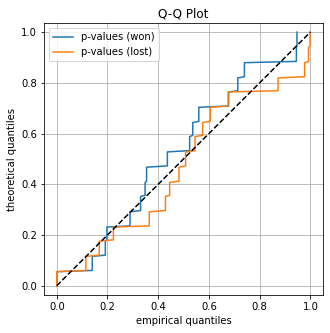

In [13]:
# Discretize beta
beta = np.linspace(0, 1, 200)

# Compute quantiles
q_theo = q_theoretical(beta)
q_won  = q_empirical(beta, data["p-value (won)"])
q_lost = q_empirical(beta, data["p-value (lost)"])

# Create Q-Q Plot
fig, ax = plt.subplots(1, 1, figsize=[5, 5])
ax.plot(q_won,  q_theo, "-", label="p-values (won)")
ax.plot(q_lost, q_theo, "-", label="p-values (lost)")
ax.plot([0, 1], [0, 1], "k--")

# Plot settings
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.axis('equal')
ax.legend()
ax.grid()
ax.set_xlabel("empirical quantiles")
ax.set_ylabel("theoretical quantiles")
ax.set_title("Q-Q Plot")
plt.show()

Of course, the two generated lines do not coincide perfectly with the $45°$ line $y = x$. That raises the question, what deviation from that line we would expect if the $p$-values were actually drawn from a uniform distribution. One way to approach this question visually is to generate multiple samples of a uniform distribution (each sample consisting of $17$ numbers, like `p-values (won)` and `p-values (lost)`) and make a Q-Q Plot for each sample. So, we basically sample Q-Q plots under $H_0$. 

**Task:** Generate multiple (e.g. $1000$) samples as described above and show the corresponding Q-Q Plots together with the two lines from the previous task. 

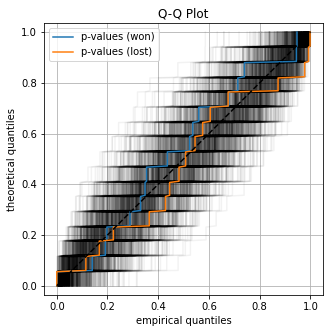

In [14]:
# Create Q-Q Plot
fig, ax = plt.subplots(1, 1, figsize=[5, 5])

# Sample Q-Q plot under H_0
rng = np.random.default_rng()
nof_samples = 1000
for sample_idx in range(nof_samples):
    sample = rng.uniform(size=17)
    ax.plot(q_empirical(beta, sample), q_theo, "-k", alpha=0.05)

ax.plot(q_won,  q_theo, "-", label="p-values (won)")
ax.plot(q_lost, q_theo, "-", label="p-values (lost)")
ax.plot([0, 1], [0, 1], "k--")

# Plot settings
ax.axis('equal')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.legend()
ax.grid()
ax.set_xlabel("empirical quantiles")
ax.set_ylabel("theoretical quantiles")
ax.set_title("Q-Q Plot")
plt.show()